In [11]:
## setup

# env.render() in Google Colab
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

# neural network
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, \
    Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

# evaluation
import imageio

In [2]:
## hyperparameters

# change
EPISODES = 100
# EPISODES = 3
PATH_MODEL_01 = 'pendulum_ddpg_actor.h5'
PATH_MODEL_02 = 'pendulum_ddpg_critic.h5'
PATH_MODEL_03 = 'pendulum_ddpg_target_actor.h5'
PATH_MODEL_04 = 'pendulum_ddpg_target_critic.h5'
# PATH_VIDEO = 'ddpg_pendulum.mp4'
PATH_VIDEO = 'ddpg_pendulum.gif'


# https://gym.openai.com/envs/Pendulum-v0/
ENV = 'Pendulum-v0'
THETA = 0.15
DT = 1e-2
BUFFER_CAPACITY = 100000
BATCH_SIZE = 64
STD = 0.2
CRITIC_LR = 0.002
ACTOR_LR = 0.001
GAMMA = 0.99
TAU = 0.005
MA = 40

# evaluation
FPS = 30

plt.style.use('default')

In [3]:
## environment

env= gym.make(ENV)

num_states = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]
upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print(f'state space: {num_states}')
print(f'action space: {num_actions}')
print(f'continuous action max: {upper_bound}')
print(f'continuous action min: {lower_bound}')

state space: 3
action space: 1
continuous action max: 2.0
continuous action min: -2.0


In [4]:
## ornstein-uhlenbeck process

class OUActionNoise:
    """
    Ornstein-Uhlenbeck process models the exploration noise process
    Use temporally correlated noise in order to explore well 
    in physical environments that have momentum.
    In paper, theta = 0.1g, sigma = 0.2
    
    https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process

    dt = derivative of t, time
    """
    # x_initial?
    def __init__(self, mean, std, theta = THETA, dt = DT, x_initial = None):
        self.theta = theta
        self.mean = mean
        self.std = std
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        x = (
            self.x_prev
             + self.theta * (self.mean - self.x_prev) * self.dt
             + self.std * np.sqrt(self.dt) * np.random.normal(size = self.mean.shape)
        )
        # it makes next noise dependent on current noise
        self.x_prev = x
        return x

    def reset(self):
        # default x_initial is None
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [5]:
## actor network and critic network

def get_actor():
    """
    Actor updates the policy distribution
    Policy outputs the value used to select action. Here it is continuous

    Initialize for the last layer of the Actor to be between -0.003 and 0.003
    This prevents us from getting 1 or -1 output values in the initial stages.
    1 or -1 would squash our gradients to zero, as using tanh activation
    
    kernel_initializer defines the way to set the initial random weights of Keras layers
    tanh, hyperbolic tangent activation function producs numbers between -1 and 1.
    Because Pendulum environment has action space -2 to 2, outputs are multipled by upper_bound (2)

    Makes tf.keras.Model by Functional API.
    """
    last_init = tf.random_uniform_initializer(minval = -0.003, maxval = 0.003)
    inputs = Input(shape = (num_states,))
    out = Dense(512, activation = 'relu')(inputs)
    out = BatchNormalization()(out)
    out = Dense(512, activation = 'relu')(out)
    out = BatchNormalization()(out)
    outputs = Dense(1, activation = 'tanh', kernel_initializer = last_init)(out)
    outputs = outputs * upper_bound
    model = Model(inputs, outputs)
    return model

def get_critic():
    """
    Critic estimates value function (Either action-value or state-value)
    Here Critic updates action-value Q(s, a), so we need state and action as input
    The model outputs action-value by Dense(1)

    Makes tf.keras.Model by Functional API
    """
    # state as input
    state_input = Input(shape = (num_states))
    state_out = Dense(16, activation = 'relu')(state_input)
    state_out = BatchNormalization()(state_out)
    state_out = Dense(32, activation = 'relu')(state_out)
    state_out = BatchNormalization()(state_out)
    # action as input
    action_input = Input(shape = (num_actions))
    action_out = Dense(32, activation = 'relu')(action_input)
    action_out = BatchNormalization()(action_out)
    # both are passed through separate layers before concatenating
    concat = Concatenate()([state_out, action_out])
    out = Dense(512, activation = 'relu')(concat)
    out = BatchNormalization()(out)
    out = Dense(512, activation = 'relu')(out)
    out = BatchNormalization()(out)
    outputs = Dense(1)(out)
    model = Model([state_input, action_input], outputs)
    return model

In [6]:
## experience replay buffer

class Buffer:
    """
    Experience replay buffer
    """
    def __init__(self, buffer_capacity = BUFFER_CAPACITY, batch_size = BATCH_SIZE):
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size
        # initialize buffer_counter which is incremented by record method
        self.buffer_counter = 0
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    def record(self, obs_tuple):
        """
        When buffer_counter > buffer_capacity,
        index has a new index starting from 0 by %
        """
        index = self.buffer_counter % self.buffer_capacity
        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        self.buffer_counter += 1

    def learn(self):
        """
        This method updates non-target Critic parameters and 
        non-target Actor parameters by computing loss and gradients.

        Critic update uses target networks, but Actor update only use non-target networks.

        Note that target Critic and target Actor are updated by TAU weighted average algorithm.
        """
        record_range = min(self.buffer_counter, self.buffer_capacity)
        batch_indices = np.random.choice(record_range, self.batch_size)

        # what is the shape of these?
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        # why?
        reward_batch = tf.cast(reward_batch, dtype = tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        # update Critic
        with tf.GradientTape() as tape:
            # Target Actor inputs state and outputs values to choose action
            target_actions = target_actor(next_state_batch)
            # Target Critic inputs state_input and action_input, and outputs action-value Q(s, a)
            y = reward_batch + GAMMA * target_critic([next_state_batch, target_actions])
            # TD error is computed by non-target Critic action-value Q(s, a)
            critic_value = critic_model([state_batch, action_batch])
            # loss function calculates mean squared loss
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))
        # calculate gradient and update non-target Critic
        critic_gradient = tape.gradient(critic_loss, critic_model.trainable_variables)
        # non-target Critic has Adam optimizer
        critic_optimizer.apply_gradients(
            zip(critic_gradient, critic_model.trainable_variables)
        )

        # update Actor
        with tf.GradientTape() as tape:
            # Non-target Actor inputs state, and outputs action
            actions = actor_model(state_batch)
            # Non-target Critic inputs state and action, and outputs action-value Q(s, a)
            critic_value = critic_model([state_batch, actions])
            # Loss function for Actor is a mean of action-values
            # negative value because we want to maximize value given by Critic?
            actor_loss = -tf.math.reduce_mean(critic_value)
        # calculate gradient and update non-target Actor
        actor_gradient = tape.gradient(actor_loss, actor_model.trainable_variables)
        # non-target Actor has Adam optimizer
        actor_optimizer.apply_gradients(
            zip(actor_gradient, actor_model.trainable_variables)
        )

In [7]:
## helper functions

def update_target(tau):
    """
    This updates target Actor and target Critic parameters slowly by
    tau wighted average algorithm.
    """
    # update target Critic
    new_weights = []
    target_variables = target_critic.weights
    for i, variable in enumerate(critic_model.weights):
        new_weights.append(variable * tau + target_variables[i] * (1 - tau))
    target_critic.set_weights(new_weights)

    # update target Actor
    new_weights = []
    target_variables = target_actor.weights
    for i, variable in enumerate(actor_model.weights):
        new_weights.append(variable * tau + target_variables[i] * (1 - tau))
    target_actor.set_weights(new_weights)

def policy(state, noise_object):
    """
    This returns an action sampled from Actor network plus noise for exploration.

    Inputs:
    state is Tensor of state with shape (1, num_states)
    noise_object is a class of Ornstein-Uhlenbeck process models

    Output:
    list of a scalar, which is sampled continuous action added noise
    """
    # tf.squeeze removes dimensions of size 1 from the shape of tensor
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # add noise to action
    sampled_actions = sampled_actions.numpy() + noise
    # make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)
    # returns a list of one scalar element
    return [np.squeeze(legal_action)]

In [ ]:
## training

# initialize
ou_noise = OUActionNoise(mean = np.zeros(1), std = float(STD))
actor_model = get_actor()
critic_model = get_critic()
target_actor = get_actor()
target_critic = get_critic()
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())
critic_optimizer = Adam(CRITIC_LR)
actor_optimizer = Adam(ACTOR_LR)
buffer = Buffer(BUFFER_CAPACITY, BATCH_SIZE)
# store reward history of each episode
ep_reward_list = []
# store average reward history of last few episodes
avg_reward_list = []

for ep in range(EPISODES):

    prev_state = env.reset()
    episodic_reward = 0

    while True:

        # tf.expand_dim returns a tensor with a length 1 axis inserted at index axis
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), axis = 0)
        # get action
        action = policy(tf_prev_state, ou_noise)
        # get next state and reward from the action
        state, reward, done, info = env.step(action)
        # append (state, action, reward, next_state)
        buffer.record((prev_state, action, reward, state))
        # collect reward
        episodic_reward += reward
        # get gradient
        buffer.learn()
        # update target Actor and target Critic
        update_target(TAU)
        # if done is True, finish episode
        if done:
            break
        # iterate state
        prev_state = state

    # collect total rewards in each episode
    ep_reward_list.append(episodic_reward)
    # calculate moving average of rewards
    avg_reward = np.mean(ep_reward_list[-MA:])
    print(f'Episode: {ep:,.0f}, avg reward: {avg_reward:,.1f}')
    avg_reward_list.append(avg_reward)

    # save models
    # if ep % SAVE_FREQ == 0:

Episode: 0, avg reward: -1,045.6
Episode: 1, avg reward: -1,279.5
Episode: 2, avg reward: -1,248.2
Episode: 3, avg reward: -1,309.6
Episode: 4, avg reward: -1,355.7
Episode: 5, avg reward: -1,376.0
Episode: 6, avg reward: -1,382.8
Episode: 7, avg reward: -1,367.1
Episode: 8, avg reward: -1,335.8
Episode: 9, avg reward: -1,319.3
Episode: 10, avg reward: -1,283.2
Episode: 11, avg reward: -1,239.3
Episode: 12, avg reward: -1,211.5
Episode: 13, avg reward: -1,189.8
Episode: 14, avg reward: -1,190.5
Episode: 15, avg reward: -1,180.1
Episode: 16, avg reward: -1,133.3
Episode: 17, avg reward: -1,077.6
Episode: 18, avg reward: -1,041.2
Episode: 19, avg reward: -995.3
Episode: 20, avg reward: -954.0
Episode: 21, avg reward: -910.9
Episode: 22, avg reward: -881.7
Episode: 23, avg reward: -850.2
Episode: 24, avg reward: -846.5
Episode: 25, avg reward: -833.2
Episode: 26, avg reward: -821.4
Episode: 27, avg reward: -812.8
Episode: 28, avg reward: -804.0
Episode: 29, avg reward: -784.4
Episode: 30,

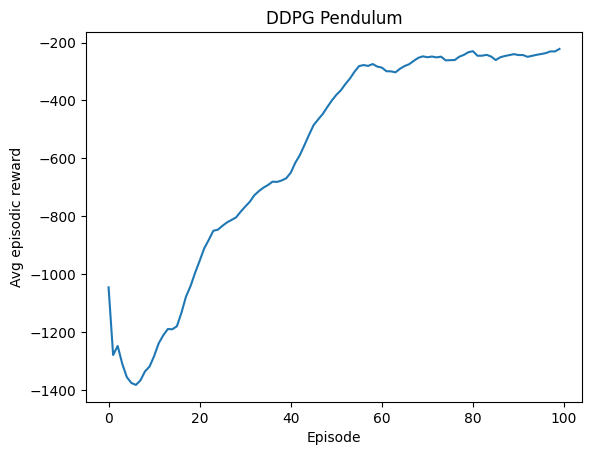

In [ ]:
## visualize training

plt.plot(avg_reward_list)
plt.title('DDPG Pendulum')
plt.xlabel('Episode')
plt.ylabel('Avg episodic reward')
plt.show()

In [ ]:
## save the weights

actor_model.save_weights(PATH_MODEL_01)
critic_model.save_weights(PATH_MODEL_02)
target_actor.save_weights(PATH_MODEL_03)
target_critic.save_weights(PATH_MODEL_04)

In [13]:
## evaluation mp4

# load model
actor_model = get_actor()
print(PATH_MODEL_03)
actor_model.load_weights(PATH_MODEL_03)

# initialize
print(ENV)
env = gym.make(ENV)
# need this in evaluation?
# maybe in evaluation, we do not need to add noise to sampled continuous action
ou_noise = OUActionNoise(mean = np.zeros(1), std = float(STD))

# make video
with imageio.get_writer(PATH_VIDEO, fps = FPS) as video:
    prev_state = env.reset()
    done = False
    screen = env.render(mode = 'rgb_array')
    video.append_data(screen)

    while not done:
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), axis = 0)
        action = policy(tf_prev_state, ou_noise)
        state, reward, done, info = env.step(action)
        screen = env.render(mode = 'rgb_array')
        video.append_data(screen)
        prev_state = state

env.close()

pendulum_ddpg_target_actor.h5
Pendulum-v0


In [50]:
# ## test policy

# # initialize
# env = gym.make(ENV)
# ou_noise = OUActionNoise(mean = np.zeros(1), std = float(STD))
# actor_model = get_actor()
# actor_model.load_weights(PATH_MODEL_03)

# prev_state = env.reset()
# print(prev_state, prev_state.shape)

# prev_state_tensor = tf.convert_to_tensor(prev_state)
# print(prev_state_tensor)

# tf_prev_state = tf.expand_dims(prev_state_tensor, axis = 0)
# print('tf_prev_state', tf_prev_state)

# action = actor_model(tf_prev_state)
# print(action)

# squeeze = tf.squeeze(action)
# print('squeeze', squeeze)

# np_squeeze = squeeze.numpy()
# print('np_squeeze', np_squeeze)

# noise = ou_noise()
# print('noise', noise)

# sampled_action = np_squeeze + noise
# legal_action = np.clip(sampled_action, lower_bound, upper_bound)
# print('legal_action', legal_action, legal_action.shape)

# returned = np.squeeze(legal_action)
# print('returned', returned, returned.shape)
# print('[returned]', [returned], type([returned]))